In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

In [15]:
ts_data = sio.loadmat('../../mackenzie_canyon/conditions/data/for_stratification/canyonTSdata2.mat')
i_ref = 0
sal_ref = ts_data['salcanyon2'][:, i_ref]
dep_ref = ts_data['depthcanyon2'][:, i_ref]*-1

In [3]:
diffs_x = np.zeros([bathy.shape[0], bathy.shape[1]-1])

diffs_y = np.zeros([bathy.shape[0]-1, bathy.shape[1]])

for n in range(bathy.shape[0]):
    diffs_x[n, :] = abs(np.diff(bathy[n, :]))

for n in range(bathy.shape[1]):
    diffs_y[:, n] = np.diff(bathy[:, n])

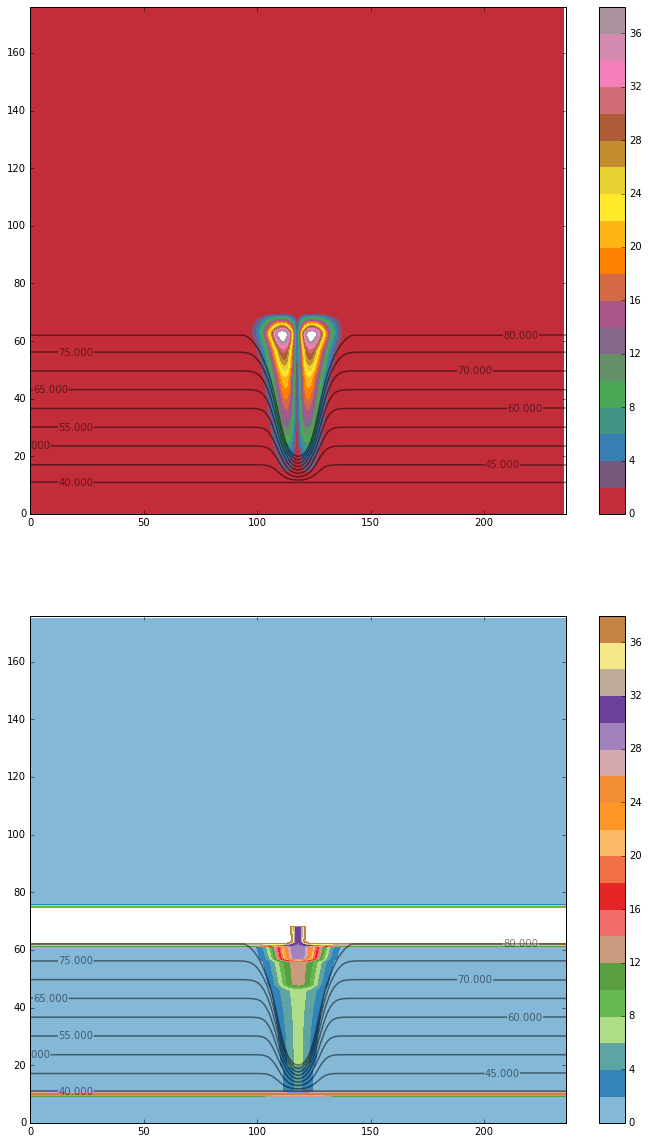

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 20))
c = ax1.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax1.clabel(c, inline=1, fontsize=10)

c = ax2.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax2.clabel(c, inline=1, fontsize=10)

cf_x = ax1.contourf(diffs_x, cmap = cm.Set1, levels=np.arange(0, 40, 2))
cf_y = ax2.contourf(diffs_y, cmap = cm.Paired, levels=np.arange(0, 40, 2))
fig.colorbar(cf_x, ax=ax1)
fig.colorbar(cf_y, ax=ax2)

In [5]:
possible_rim_points = np.where((abs(diffs_x) >= 2) & (abs(diffs_x) <= 4))
possible_rim_points_x = possible_rim_points[1]
possible_rim_points_y = possible_rim_points[0]

vertical = np.where((abs(diffs_y) >= 2) & (abs(diffs_y) <= 4))
xvertical = vertical[1]
yvertical = vertical[0]

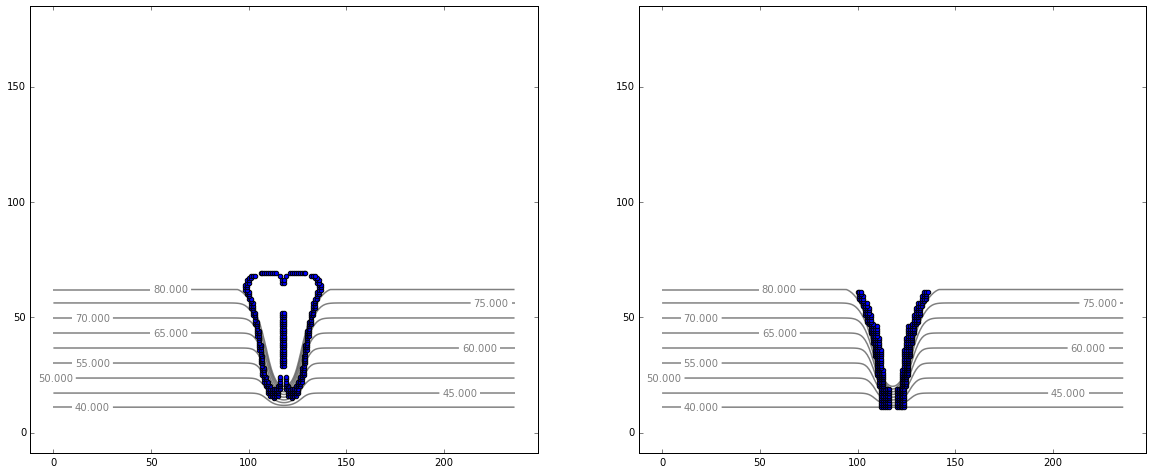

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 8))
c = ax1.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax1.clabel(c, inline=1, fontsize=10)

c = ax2.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax2.clabel(c, inline=1, fontsize=10)

ax1.scatter(possible_rim_points_x, possible_rim_points_y)
ax2.scatter(xvertical, yvertical)

In [8]:
# many points satisfy the gradient condition
# the unique y coordinates are found for all possible points
unique_ys = np.unique(possible_rim_points_y)
rim_inds = np.zeros([len(unique_ys), 3])
for n in range(len(unique_ys)):
    # isolate one of the unique y-coordinates
    individual_y = unique_ys[n]
    # there will be many points along the same y-coordinate
    # this finds the indices for all points along the unique y-coordinate
    inds_individual_y = np.where(possible_rim_points_y==individual_y)
    # this finds the corresponding x-coordinates for the unique y-coordinate
    inds_x_for_individual_y = itemgetter(*inds_individual_y)(possible_rim_points_x)
    # we now have all x-coordinates along the unique y-coordinate
    # this gives the smallest x-coordinate (west)
    individual_x_min = inds_x_for_individual_y.min()
    # this gives the biggest x-coordinate (east)
    individual_x_max = inds_x_for_individual_y.max()
    # they are stored into one n-d array
    rim_inds[n,0] = individual_x_min
    rim_inds[n,1] = individual_x_max
    rim_inds[n,2] = individual_y

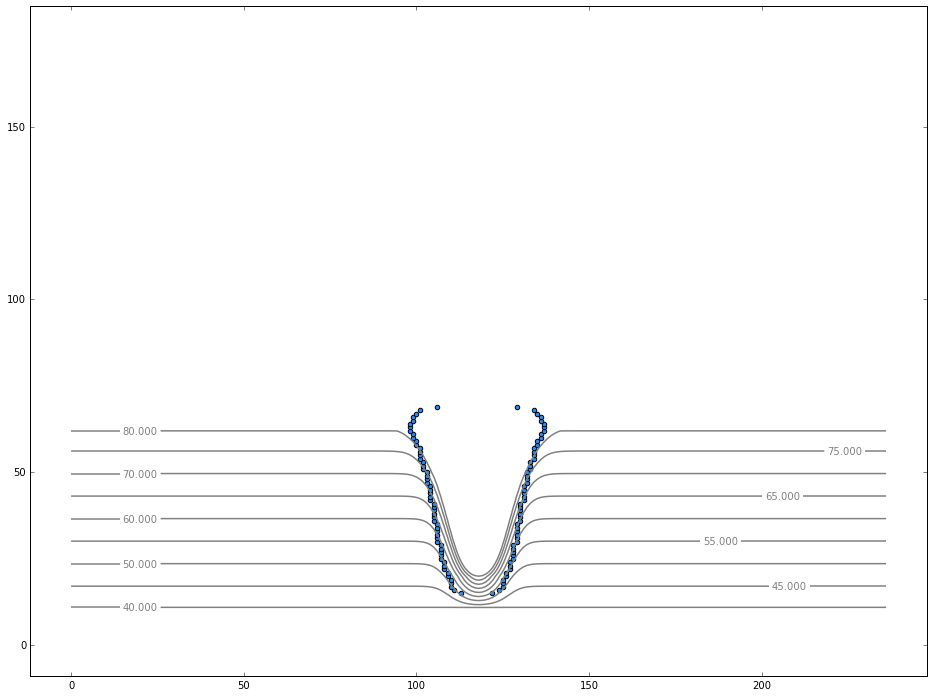

In [9]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*12, 12))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=1.5)
ax.clabel(c, inline=1, fontsize=10)

ax.scatter(rim_inds[:,0], rim_inds[:,2], c='dodgerblue')
ax.scatter(rim_inds[:,1], rim_inds[:,2], c='dodgerblue')

In [ ]:
def calculate_upwelling_depth(sal_profiles_rim, sal_ref, dep_ref, depth_levels):
    depth_change = np.zeros(sal_profiles_rim.shape[1])
    for y_ind in range(sal_profiles_rim.shape[1]):
        sal_column = sal_profiles_rim[:,y_ind]
        try:
            ind_nanmax = np.where(sal_column == np.nanmax(sal_column))[0][0]
        except IndexError:
            ind_nanmax = 0
        sal_result = sal_column[ind_nanmax]
        ind_result_nearest_ref = min(range(len(sal_ref)), key=lambda i: abs(sal_ref[i]-sal_result))
        d_ref = dep_ref[ind_result_nearest_ref]
        d_new = depth_levels[ind_nanmax]
        depth_change[y_ind] = d_ref - d_new
    return depth_change, d_new